# 编码器
在编码器接口中，我们只指定长度可变的序列作为编码器的输入x。任何继承这个Encoder基类的模型将完成代码实现。

In [1]:
from torch import nn


#@save
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""

    def __int__(self, **kwargs):
        super(Encoder, self).__int__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

# 解码器

在下面的解码器接口中，，新增一个init_state函数，用于将编码器的输出enc_outputs转换为编码后的状态。注意，此步骤可能需要额外的输入（如：输入序列的有效长度）。

为了逐个地生成长度可变的词元序列， 解码器在每个时间步都会将输入 （例如：在前一时间步生成的词元）和编码后的状态映射成当前时间步的输出词元。

In [2]:
#@save
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""

    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        """将编码器的输出（enc_outputs）转换为编码后的状态"""
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

# 合并编码器和解码器

编码器-解码器架构包含了一个编码器和一个解码器，并且还拥有可选的额外参数。在前向传播中，编码器的输出用于生成编码状态，这个状态又被解码器作为其输入的一部分。

In [3]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""

    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

编辑器-解码器体系中的术语状态会启发人们使用具有状态的神经网络来实现该架构

# Seq2Seq序列

机器翻译中的输入序列和输出序列都是长度可变的，为解决这一问题，设计了一种通用的”编码器-解码器“架构。本节将使用两个循环神经网络的编码器和解码器，并将其应用到Seq2Seq类的学习任务。

遵循编码器-解码器脚骨设计原则，循环神经网络编码器使用长度可变的序列作为输入，将其转换为固定形状的隐状态。换言之，输入序列的信息被编码到循环神经网络的隐状态中。为了连续生成输出序列的词元，独立的循环神经网络解码器是基于输入序列的编码信息和输出序列的已经看见或者生成的词元来预测下一词元。

下面演示如何在机器翻译中使用两个循环神经网络进行序列到序列学习。

在循环神经网络解码器的初始化时间步，有两个特定的设计决定：
* 特定的“<bos>”表示序列开始词元，它是解码器的输入序列的第一个词元
* 特定的“<eos>”表示序列结束词元。 一旦输出序列生成此词元，模型就会停止预测

在其他一些设计中，编码器最终的隐状态在每一个时间步都作为解码器的输入序列的一部分。可以允许标签成为原始的输出序列，从源序列词元“<bos>”“Ils”“regardent”“.” 到新序列词元 “Ils”“regardent”“.”“<eos>”来移动预测的位置。

In [4]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

从技术上讲，编码器将长度可变的输入序列转换成形状固定的上下文变量c，并且将输入序列的信息在该上下文变量中进行编码。可以使用循环神经网络来设计编码器。

In [5]:
#@save
class Seq2SeqEncoder(Encoder):
    """用于Seq2Seq循环神经网络编码器"""

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)  #嵌入层
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

下面，我们实例化上述编码器的实现： 我们使用一个两层门控循环单元编码器，其隐藏单元数为。 给定一小批量的输入序列X（批量大小为4，时间步为7）。 在完成所有时间步后， 最后一层的隐状态的输出是一个张量（output由编码器的循环层返回）， 其形状为（时间步数，批量大小，隐藏单元数）。

In [6]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  #批量大小为4，时间步为7
output, state = encoder(X)
print(output.shape)  #（时间步数，批量大小，隐藏单元数）
print(state.shape)  #（层数，批量大小，隐藏单元数）

torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


为了在序列上模型化这种条件概率， 我们可以使用另一个循环神经网络作为解码器。

In [7]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出X的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

下面，我们用与前面提到的编码器中相同的超参数来实例化解码器。 如我们所见，解码器的输出形状变为（批量大小，时间步数，词表大小）， 其中张量的最后一个维度存储预测的词元分布。

In [8]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
print(output.shape)
print(state.shape)

torch.Size([4, 7, 10])
torch.Size([2, 4, 16])


# 损失函数

在每个时间步，解码器预测了输出词元的概率分布。 类似于语言模型，可以使用softmax来获得分布， 并通过计算交叉熵损失函数来进行优化。 回想一下9.5节中， 特定的填充词元被添加到序列的末尾， 因此不同长度的序列可以以相同形状的小批量加载。 但是，我们应该将填充词元的预测排除在损失函数的计算之外。

为此，我们可以使用下面的sequence_mask函数通过零值化屏蔽不相关的项， 以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。 例如，如果两个序列的有效长度（不包括填充词元）分别为1和2， 则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。

In [9]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    # device=X.device表示使用与张量X相同的设备（CPU或GPU）
    X[~mask] = value
    return X


X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

我们还可以使用此函数屏蔽最后几个轴上的所有项。如果愿意，也可以使用指定的非零值来替换这些项。

In [10]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。 最初，所有预测词元的掩码都设置为1。 一旦给定了有效长度，与填充词元对应的掩码将被设置为0。 最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [11]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""

    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)  #其实就是在原来的loss中乘一个01的weights，把为0的全部消掉
        return weighted_loss

我们可以创建三个相同的序列来进行代码健全性检查， 然后分别指定这些序列的有效长度为4、2和0。结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。

In [12]:
loss = MaskedSoftmaxCELoss()
weighted_loss = loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))
# print(torch.ones(3, 4, 10))
# print(torch.ones((3, 4), dtype=torch.long))
print(weighted_loss)

tensor([2.3026, 1.1513, 0.0000])


# 训练

在下面的循环训练过程中，如 图9.7.1所示， 特定的序列开始词元（“<bos>”）和 原始的输出序列（不包括序列结束词元“<eos>”） 拼接在一起作为解码器的输入。 这被称为强制教学（teacher forcing）， 因为原始的输出序列（词元的标签）被送入解码器。 或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。

In [13]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""

    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)  #初始化编码器-解码器模型net的权重
    net.to(device)  #设置训练设备（是gpu还是cpu）
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  #选择Adam优化器对net中的参数进行优化
    loss = MaskedSoftmaxCELoss()  #设置损失函数
    net.train()  #训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])  #创建了一个动画显示器（animator），用于实时可视化训练过程中的损失变化
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  #创建了一个具有2个指标槽位的度量器
        for batch in data_iter:
            optimizer.zero_grad()  #梯度清零
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]  #解包
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)  #开始标记
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  #将开始标记与Y标签（移除了最后一列）按维度1拼接
            Y_hat, _ = net(X, dec_input, X_valid_len)  #输出每个epoch的预测值
            l = loss(Y_hat, Y, Y_valid_len)  #计算损失函数
            l.sum().backward()  #损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)  #对梯度进行裁剪以防止梯度爆炸
            num_tokens = Y_valid_len.sum()  #词元总数
            optimizer.step()  #优化器参数更新
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)  #将loss总和和词元数量添加至度量器
            """
            with torch.no_grad()是一个上下文管理器，用于指定在其内部的代码块中不计算梯度。在这个代码块中，所有的张量操作都不会被记录梯度，从而避免了对梯度的计算和存储，以提高代码的执行效率。
            在这段代码中，metric.add(l.sum(), num_tokens)用于计算并添加损失l和标记数num_tokens到指定的度量器（metric）中。由于在这里使用了torch.no_grad()，所以在计算和添加操作中不会计算梯度，只会进行正常的数值计算。
            使用torch.no_grad()上下文管理器的场景通常是在评估模型或计算验证集上的指标时，因为这些操作不需要进行梯度计算，而只关心输出的数值结果。
            """
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

现在，在机器翻译数据集上，我们可以 创建和训练一个循环神经网络“编码器－解码器”模型用于序列到序列的学习。

loss 0.019, 12158.4 tokens/sec on cuda:0


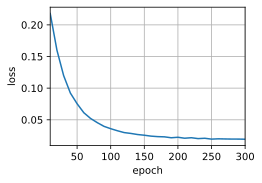

In [14]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
#train_iter 是一个迭代器，用于遍历训练数据集的批次
# src_vocab 是源语言的词汇表，它是一个映射（mapping），将源语言的单词映射为唯一的整数标识
# tgt_vocab 是目标语言的词汇表，它将目标语言的单词映射为整数标识。
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)  #创建编码器对象
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)  #创建解码器对象
net = EncoderDecoder(encoder, decoder)  #创建编码器-解码器对象
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)


In [21]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    """序列到序列模型的预测"""
    net.eval()  # 在预测时将net设置为评估模式
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']] #将输入的源语言句子src_sentence转换为词元表示，并添加<eoc>结束词元
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)  #记录源语言句子的有效长度
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])    #对源语言句子进行填充或截断
    # 添加批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)   #初始化编码器的输入
    enc_outputs = net.encoder(enc_X, enc_valid_len) #将源语言句子输入编码器（net.encoder）得到编码器的输出 enc_outputs
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)  #初始化解码器的隐藏状态
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)     #初始化解码器的输入 dec_X，将其设置为 <bos> 开始词元
    output_seq, attention_weight_seq = [], []
    # 进行循环迭代，每次迭代都进行解码器的前向计算。
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)    #在每个时间步，使用解码器的当前输入 dec_X 和隐藏状态 dec_state 进行前向计算，得到输出 Y 和更新后的隐藏状态 dec_state
        dec_X = Y.argmax(dim=2) # 使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()    #预测到的词元
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred) #将预测的词元添加到output_seq中
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq  #返回预测的目标语言句子以及存储预测的词元索引序列的列表

我们可以通过与真实的标签序列进行比较来评估预测序列。 虽然 (Papineni et al., 2002) 提出的BLEU（bilingual evaluation understudy） 最先是用于评估机器翻译的结果， 但现在它已经被广泛用于测量许多应用的输出序列的质量。 原则上说，对于预测序列中的任意n元语法（n-grams）， BLEU的评估都是这个n元语法是否出现在标签序列中。

我们将BLEU定义为:
$$
\exp \left(\min \left(0,1-\frac{\text { len }_{\text {label }}}{\operatorname{len}_{\text {pred }}}\right)\right) \prod_{n=1}^{k} p_{n}^{1 / 2^{n}}
$$

其中len_label表示标签序列中的词元数和len_pred表示预测序列中的词元数，k是用于匹配的最长的n元语法。另外，用pn表示n元语法的精确度，它是两个数量的比值：第一个是预测序列与标签序列中匹配的n元语法的数量，第二个是预测序列中n元语法的数量的比率。具体地说，给定标签序列A量、B、C、D、E、F和预测序列A、B、B、C、D，我们有p1=4/5、p2=3/4、p3=1/3和p4= 0.

根据（9.7.4）中BLEU的定义，当预测序列与标签序列完全相同时，BLEU为1。此外，由于n元语法越长则匹配难度越大，所以BLEU为更长的n元语法的精确度分配更大的权重。具体来说，当pn固定时，p1/2"会随着n的增长而增加（原始论文使用p1/"）。而且，由于预测的序列越短获得的pn值越高，所以（9.7.4）中乘法项之前的系数用于惩罚较短的预测序列。例如，当k=2时，给定标签序列A.B.C、D、E、F和预测序列A、B，尽管p1= p2= 1，惩罚因子exp（1-6/2）~ 0.14会降低BLEU。

In [22]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU，pred_seq是预测的序列，label_seq是标签的序列，k是BLEU的n-gram参数"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最后，利用训练好的循环神经网络“编码器－解码器”模型， 将几个英语句子翻译成法语，并计算BLEU的最终结果。

In [24]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va <unk> !, bleu 0.000
i lost . => j'ai perdu perdu ., bleu 0.783
he's calm . => il est mouillé tomber ?, bleu 0.447
i'm home . => je suis chez moi prie ., bleu 0.803
